# PID 101 for Robotics: Part II — Tuning

Copyright &copy; 2023 [Joshua Marshall](https://offroad.engineering.queensu.ca/people/joshua-marshall/)

The purpose of this hands-on notebook is to explain and demonstrate via simulation how to design and implement (in discrete time) an easily tunable [Proportional-Integral-Derivative (PID) controller](PID-101-Part1.ipynb) for single-input single-output (SISO) systems that are inherently stable.  The systematic approach presented here is suitable for many physical systems (e.g., robots, motors, etc.).  An introduction to PID is provided in: [Part I — Basics](PID-101-Part1.ipynb). 

## PID Controller Design

Let $x(t)\in\mathbb{R}$ be the system state to be controlled and suppose that the control objective is to use the system input $u(t)\in\mathbb{R}$ to drive $x(t)\rightarrow x_{\rm d}$ as $t\rightarrow\infty$ with some desired transient performance.  To this end, a PID controller takes the general form

$$u(t)=k_{{\rm P}}(x_{\textup{d}}-x(t)) + k_{{\rm I}}\int_0^t(x_{\textup{d}}-x(\tau))d\tau + k_{{\rm D}}\frac{\textup{d}}{\textup{d}t}(x_{\textup{d}}-x(t)),$$

where $k_{{\rm P}},k_{{\rm I}},k_{{\rm D}}\in\mathbb{R}$ are the proportional, integral, and derivative controller gains, respectively.  In the [Laplace domain](https://en.wikipedia.org/wiki/Laplace_transform), the above PID controller is equivalent to

$$U(s) = \left(k_{{\rm P}} + \frac{k_{{\rm I}}}{s} + k_{{\rm D}} s \right)\left(\frac{x_{\textup{d}}}{s} - X(s)\right),$$

where $s\in\mathbb{C}$ is the Laplace variable, $U(s):=\mathcal{L}(u(t))$, and $X(s):=\mathcal{L}(x(t))$.

Given a specific application, whether all or only some of the P, I, and D terms are required and how to appropriately choose the gains $k_{{\rm P}}, k_{{\rm I}},k_{{\rm D}}\in\mathbb{R}$ is the task of control systems engineering.  Many users, unfortunately, skip the design stage and simply guess and/or tune by trial-and-error.  Instead, this note provides a relatively straightforward way to carry out controller design for two common types of SISO systems.

## Controller Design Objectives

Choosing the structure of a controller and its parameters (i.e., _tuning_ controller gains) depends on the performance requirements.  In many applications (e.g., in robotics), we usually have two design objectives.

1. We would like that the tracking error for step inputs to the reference signal to be zero.  Moreover, we would like to track comparatively low [bandwidth](https://en.wikipedia.org/wiki/Bandwidth_(signal_processing)) signals up to a specified frequency of $\omega_{\rm d}>0$ with a small a tracking error as possible. Practically speaking, the physics of the system itself will likely determine how high you can make this frequency.

2. We would like the closed-loop response to have very high damping (i.e., smooth behaviour with minimal oscillations).  This usually makes sense for most mechanical systems (e.g., motors, robots).

It can be shown via the final value theorem that the [sensitivity function](https://en.wikipedia.org/wiki/Sensitivity_(control_systems)) [[1, p. 270]](#references)

$$S(s):=\frac{1}{1+P_0(s)C(s)},$$

where $C(s)$ is our controller design, determines the steady-state tracking error $e(\infty)$; i.e., 

$$e(\infty)=\lim_{s\rightarrow 0}sS(s)\frac{1}{s} = S(0) = 0$$

for the steady-state error corresponding to a step input in the reference signal. Thus, our design objectives can be satisfied if the sensitivity function is first order (no overshoot) and of the form

$$S(s)=\frac{s}{s+\omega_{{\rm CL}}},$$

where $\omega_{{\rm CL}}>0$ is approximately the closed-loop bandwidth of the controlled system.

To track reference signals up to a bandwidth of $\omega_{\rm d}>0$, we want that

$$\left|\frac{j\omega_{\rm d}}{j\omega_{\rm d}+\omega_{{\rm CL}}}\right|\leq \delta,$$

where $j:=\sqrt{-1}$ and $\delta<1$ is sufficiently small. Rearranging, we find that
  
$$\omega_{{\rm CL}}\geq\frac{\sqrt{1-\delta^2}}{\delta}\omega_{\rm d}.$$

This shows that the tracking error for signals up to frequency $\omega_{\rm d}$ can be improved by increasing the bandwidth of the closed-loop system (i.e., increasing the [loop gain](https://en.wikipedia.org/wiki/Loop_gain)).

## Controller Design & Examples

We assume that the plant is itself [stable](https://en.wikipedia.org/wiki/Control_theory#Stability).  In this case, it can be shown that the set of all stabilizing controllers is given by [[2, 3]](#references)

$$C(Q(s)) = \frac{Q(s)}{1-P_0(s)Q(s)},$$

where $Q(s)$ is any stable, proper, and real rational transfer function.  By the definition of $S(s)$,
  
$$S(s) = 1 - P_0(s)Q(s),$$

such that we obtain
  
$$Q(s) = \frac{1-S(s)}{P_0(s)}.$$

Let us now see how to use this methodology for first- and second-order plants.

### Controller Design for First-Order Systems

Consider a common first-order plant with transfer function
  
  $$P_0(s) = \frac{a}{s+b}.$$

Note that the steady-state value for this plant is $P_0(0) = a/b$.

According to our design requirements, we would like a sensitivity function of the form given above.  In other words, we would like to find
  
$$Q(s) = \left(\frac{s+b}{a}\right)\left(1-\frac{s}{s+\omega_{\rm CL}}\right) = \frac{\omega_{\rm CL}}{a}\left(\frac{s+b}{s+\omega_{\rm CL}}\right).$$

Substituting this into our expression for $C(s)$ above yields

$$C(s) = \frac{\omega_{\rm CL}}{a}\left(\frac{s+b}{s+\omega_{\rm CL}}\right)\left(\frac{s+\omega_{\rm CL}}{s}\right) = \frac{\omega_{\rm CL}}{a}\left(1+\frac{b}{s}\right),$$

which is merely a PI controller of the form
  
$$C(s) = k_{{\rm P}} + \frac{k_{{\rm I}}}{s},$$

with proportional and integral controller gains
  
$$k_{{\rm P}} = \frac{1}{a}\omega_{\rm CL},\, k_{{\rm I}} = \frac{b}{a}\omega_{\rm CL}.$$

Thus, to tune this controller we now have only to adjust the closed-loop bandwidth $\omega_{\rm CL}>0$.  Ideally we would like to make this as high as possible, although we will of course be limited by the actual dynamics of the system to be controlled.  To tune this, start low and gradually (i.e., safely) turn it up!

### Numerical Example: Vehicle Cruise Control

In this numerical example we demonstrate the above methodology by way of a simplified cruise control example for a one-dimensional vehicle or mobile robot driving along a road or path.  

Let $v(t)$ [m/s] be the speed of the vehicle and suppose that the vehicle has mass $m>0$ [kg], a drag coefficient $c_{\rm d}>0$ [kg/s], and that our actuator applies a force $u(t)\in\mathbb{R}$ [N].  Applying [Newton's Second Law](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion#Second), we find

$$u(t)-c_{\rm d}v(t)=m\dot{v}(t)$$

such that 

$$\dot{v}(t) = -\frac{c_{\rm d}}{m}v + \frac{1}{m}u(t).$$

In the Laplace domain, this is equivalent to the system transfer function
  
$$P(s)=\frac{V(s)}{U(s)} = \frac{1/m}{s+c_{\rm d}/m},$$

which is clearly first-order.  Let's simulate the vehicle's response to a step input in $u(t)$.  

#### Import Packages

We use [NumPy](http://numpy.org) for arrays and [Matplotlib](http://matplotlib.org) for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Simulation Setup

Set the simulation time as `SIM_TIME` [s], the sample period $T>0$ as `T` [s], the mobile robot's mass $m$ as `MASS` [kg], and the drag coefficient $c_{\rm d}$ as `C_DRAG` [kg/s].

In [2]:
SIM_TIME = 6.0
T = 0.1
MASS = 1.5
C_DRAG = 2.0

 Set up an array of simulation times `t` and find the total number of simulation data points `N`.

In [3]:
t = np.arange(0, SIM_TIME, T)
N = np.size(t)

 Write a function to model the mobile robot's speed $v$ as `v` [m/s] as a function of the force input $u$ as `u` [N], where $u_k=u(kT)$, $k=0,1,2,\ldots$ is applied as a zero-order hold such that

 $$v_{k+1} = v_{k} + T \frac{1}{m}(u_k - cv_k).$$

In [4]:
def vehicle_speed(v, u, T):
    """Discrete-time 1D vehicle speed model."""

    v_new = v + T * 1 / MASS * (u - C_DRAG * v)
    return v_new

#### Simulate a Step Input Response

Apply a step input of magnitude `U_STEP` [N] to the vehicle.

In [5]:
U_STEP = 4.0

Initialize the variable arrays and the initial conditions

In [6]:
v = np.zeros(N)
u = np.zeros(N)
v[0] = 0.0
u[0] = 0.0

For each time step, simulate the vehicle motion.

In [7]:
for k in range(1, N):
    # Run the vehicle speed model for one time step
    v[k] = vehicle_speed(v[k - 1], u[k - 1], T)
    # Change (step) the input part way through the simulation
    if k < N / 4:
        u[k] = 0.0
    else:
        u[k] = U_STEP

#### Plot the Simulation Output

These are some optional setup items for plotting.

In [8]:
# So we can use LaTeX in our text
plt.rc("text", usetex=True)

# So we can use some additional math features in our text
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

# Some options for saving figures
plt.rc("savefig", format="pdf")
plt.rc("savefig", bbox="tight")

Plot the speed and control input versus time.

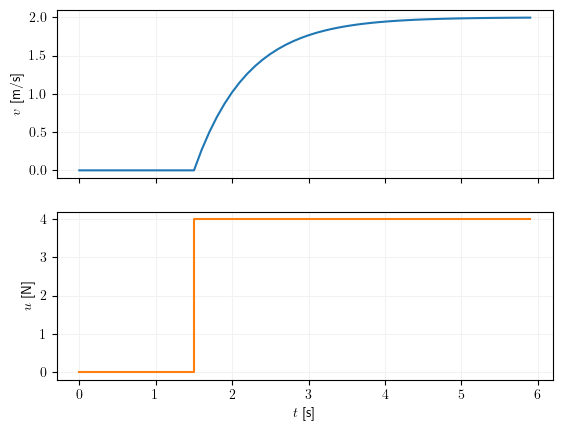

In [9]:
fig1 = plt.figure(1)
ax1a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax1a, xticklabels=[])
ax1b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-step-input.pdf")
plt.show()

> If we did not already know the model parameters $m$ and $c_{\rm d}$ (as we do in the case of this fabricated simulation), we could do a test on our real system by applying a step input $u(t)$ to the plant.  These parameters of the model could then be [identified](https://en.wikipedia.org/wiki/System_identification) from the step response $v(t)$, which should look similar to the plot above if the system is approximately first-order.

#### Closed-Loop Control

Let's now apply our controller design for first-order systems, derived above.  In this example, $a:=1/m$ and $b:=c_{\rm d}/m$, which we use to find the controller gains as `k_P` and `k_I`.  We must first choose the desired close-loop bandwidth $\omega_{\rm CL}$ [rad/s] as `OMEGA_CL`.  

> For a real-world implementation, you might start with a low value for $\omega_{\rm CL}>0$ and then gradually turn it up.

In [10]:
OMEGA_CL = 2.0

Now we can compute the controller gains using our derived formulae.

In [11]:
a = 1 / MASS
b = C_DRAG / MASS
k_P = (1 / a) * OMEGA_CL
k_I = (b / a) * OMEGA_CL

Let's choose a desired speed setting for our cruise control $v_{\rm d}$ [m/s] as `V_DESIRED`.

In [12]:
V_DESIRED = 4.0

Suppose our vehicle has a maximum available propulsion force `U_MAX` [N].

In [13]:
U_MAX = 20.0

Now simulate the closed-loop control system.  First, initialize some variable arrays and set the initial conditions.

In [14]:
v = np.zeros(N)
u = np.zeros(N)
v[0] = 0.0
u[0] = 0.0

Create a class `PI_Controller` for a PI controller design.

In [15]:
class PI_Controller:
    """Proportional-Integral (PI) controller class."""

    def __init__(self, k_P, k_I, u_max, T):
        """Constructor method.

        Parameters
        ----------
        k_P : float
            Proportional gain.
        k_I : float
            Integral gain.
        u_max : float
            Maximum control signal output magnitude.
        T : float
            Sample period [s].
        """

        self.k_P = k_P
        self.k_I = k_I
        self.T = T
        self.e_integral = 0.0
        self.u_max = u_max

    def compute_PI(self, e):
        """Compute the controller output.

        Parameters
        ----------
        e : float
            Error signal.

        Returns
        -------
        u : float
            Control signal (controller output).
        """

        # Compute the control signal output
        u = self.k_P * e + self.k_I * self.e_integral

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # Only integrate if control signal is not saturated (anti-windup)
            self.e_integral += self.T * e

        return u

For each time step, simulate the vehicle motion and compute the next control input by using a PI controller.

In [16]:
controller = PI_Controller(k_P, k_I, U_MAX, T)

for k in range(1, N):
    v[k] = vehicle_speed(v[k - 1], u[k - 1], T)
    u[k] = controller.compute_PI(V_DESIRED - v[k])

Plot the simulation results.

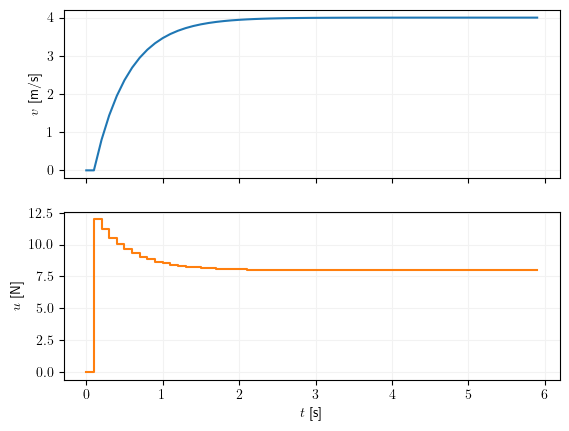

In [17]:
fig2 = plt.figure(2)
ax2a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax2a, xticklabels=[])
ax2b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()

Play around with the closed-loop bandwidth $\omega_{\rm CL}>0$.  Your chosen performance criteria should remain the same but with higher or lower bandwidth (and corresponding demand on the control signal $u$).

Note that we have also implemented input saturation nor [integrator anti-windup](https://en.wikipedia.org/wiki/Integral_windup), both of which should be used for real-world implementations.

### Controller Design for Second-Order Systems

Now we consider a common second-order plant with transfer function

$$P_0 = \frac{a}{s^2 + bs + c}.$$

Note that the steady-state gain for this plant is $P_0(0)= a/c$.

Recall that, for our approach to work, $Q(s)$ must be a stable and proper transfer function.  Substituting our second-order plant transfer function and our chosen sensitivity function $S(s)$ above into our expression for $Q(s)$ we obtain

$$Q(s) = \frac{1-S(s)}{P_0(s)} = \left(\frac{s^2+bs+c}{a}\right)\left(1-\frac{s}{s+\omega_{\rm CL}}\right).$$

However, in this case $Q(s)$ is not proper.  Therefore, we try a slightly different sensitivity function

$$\tilde{S}(s) = \frac{s(s+2\omega_{\rm CL})}{(s+\omega_{\rm CL})^2},$$

which also has the property that $\tilde{S}(0)=0$.  This yields

$$Q(s) = \frac{\omega_{\rm CL}^2}{\left(s+\omega_{\rm CL}\right)^2}\left(\frac{s^2 + bs + c}{a}\right).$$

Substituting this into our expression for $C(s)$ we find

$$C(s) = \frac{\omega_{\rm CL}^2}{a\left(s+2\omega_{\rm CL}\right)}\left(b + \frac{c}{s} + s\right),$$

which is a first-order low-pass filter together a PID controller of the form

$$C(s) = \frac{\omega_{\rm c}}{s+\omega_{\rm c}}\left(k_{\rm P} + \frac{k_{\rm I}}{s} + k_{\rm D}s\right),$$

where the filter cut-off $\omega_{\rm c}$ frequency and controller gains are

$$\omega_{\rm c} = 2\omega_{\rm CL},\ k_{\rm P} = \frac{b\omega_{\rm CL}}{2a},\ k_{\rm I} = \frac{c\omega_{\rm CL}}{2a},\ k_{\rm D} = \frac{\omega_{\rm CL}}{2a}.$$

Notice how the cut-off frequency is twice the closed-loop bandwidth (i.e., [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency)).

### Numerical Example: DC Motor Speed Control

Consider a DC motor where the input is a voltage $v$ [V] and the output is the rotational speed of the motor $\dot{\theta}$ $[\textup{rad/s}]$.  Let $J$ $[\textup{kg m}^2]$ be the rotor's moment of inertia, $b_{\textup{f}}$ $[\textup{N m s}]$ be the motor's viscous friction constant, $K_{\textup{e}}$ $[\textup{V/rad/s}]$ be the electromotive force constant, $K_{\textup{t}}$ $[\textup{N m/A}]$ be the motor torque constant, $R$ $[\Omega]$ be the electric resistance, and $L$ $[\textup{H}]$ be the electric inductance.  

Let's assume that the magnetic field is constant such that

$$\tau = K_{\textup{t}} i,$$

where $i$ $[\textup{A}]$ is the armature current. The back emf $e$ $[\textup{V}]$ is given by

$$e = K_{\textup{e}}\dot{\theta}.$$

Therefore, we can apply Newton's Second Law to find

$$J\ddot{\theta} + b_{\textup{f}}\dot{\theta} = K_{\textup{t}} i.$$

Applying Kirchhoff's Voltage Law, we find

$$L\frac{\textup{d}i}{\textup{d}t} + Ri = v - K_{\textup{e}}\dot{\theta}$$

Take the Laplace transform of these dynamical equations, we find that

$$
\begin{align*}
    Js^2\Theta(s)+b_{\textup{f}}s\Theta(s) &= K_{\textup{t}}I(s) \\ 
    LsI(s) + RI(s) &= V(s) - K_{\textup{e}}s\Theta(s),
\end{align*}
$$

which simplifies to

$$
\begin{align*}
    s\Theta(s)(Js+b_{\textup{f}}) &= K_{\textup{t}}I(s) \\ 
    (Ls + R)I(s) &= V(s) - K_{\textup{e}}s\Theta(s),
\end{align*}
$$

and, by combining the two equations to eliminate $I(s)$, yields the transfer function

$$\frac{s\Theta(s)}{V(s)} = \frac{\frac{K_{\textup{t}}}{JL}}{s^2+\frac{b_{\textup{f}}L+RJ}{JL}s + \frac{b_{\textup{f}}R+K_{\textup{e}} K_{\textup{t}}}{JL}},$$

which is a second-order system.

#### Simulation Setup

Set the simulation parameters.

In [18]:
SIM_TIME = 6.0
T = 0.1
t = np.arange(0, SIM_TIME, T)
N = np.size(t)

Set the motor parameters for simulation purposes.

In [19]:
J = 0.01
B_FRICTION = 0.01
K_E = 0.01
K_T = 0.01
R = 1
L = 0.5

Write a function to model the motor's speed as a function of the voltage input $v$.  Because our simulation happens in the time domain, we use a state-space realization of our motor modal for simulation purposes.  Let $x_1:=\dot{\theta}$ and $x_2:=i$ be the states for our second-order system.  This yields

$$
\underbrace{\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}}_{\dot{\mathbf{x}}} = 
\underbrace{\begin{bmatrix}
-\frac{b_{\textup{f}}}{J} & \frac{K_{\textup{t}}}{J} \\
-\frac{K_{\textup{e}}}{L} & -\frac{R}{L}
\end{bmatrix}}_{\mathbf{A}}
\underbrace{\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}}_{\mathbf{x}}
+ \underbrace{\begin{bmatrix}
0 \\
\frac{1}{L}
\end{bmatrix}}_{\mathbf{B}}
v.
$$

We want the ouput $\dot{\theta}=\mathbf{C}\mathbf{x}=x_1$, such that $\mathbf{C}=\begin{bmatrix}1 & 0\end{bmatrix}$.

In [20]:
A = np.array([[-B_FRICTION / J, K_T / J], [-K_E / L, -R / L]])
B = np.array([[0], [1.0 / L]])
C = np.array([[1.0, 0]])

To simulate thes system, let's find a discrete-time equivalent using sample period $T>0$. We use the notation $\mathbf{x}_k:=\mathbf{x}(kT)$, where $k=0,1,2,\ldots$ is the time step.  If the voltage input is held constant between time steps (i.e., zero-order hold), then a discrete-time model for the system is given by

$$\mathbf{x}_{k+1} = \mathbf{F}\mathbf{x}_k + \mathbf{G}v_k,$$

where

$$ 
\begin{align*}
\mathbf{F} &= e^{\mathbf{A}T} \\
\mathbf{G} &= \mathbf{F}\int_{0}^Te^{-\mathbf{A}\tau}\textup{d}\tau\mathbf{B}.
\end{align*}
$$

We use [scipy.signal.cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) to do the conversion for us. For zero-order hold, use the method `zoh`.

In [21]:
from scipy.signal import cont2discrete

dt_system = cont2discrete((A, B, C, np.array([[0.0]])), T, method="zoh")
F = dt_system[0]
G = dt_system[1]
H = dt_system[2]

Create a function to implement the DC motor's state-space model.

In [22]:
def motor_speed(x, v):
    """Discrete-time DC motor speed model."""

    x_new = F @ x + G @ [v]
    return x_new

Simulate a step input response to check the model's behaviour.

In [23]:
# Set the step input value [V]
V_STEP = 5

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
v = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
v[0] = 0.0

for k in range(1, N):
    # Run the motor speed model for one time step
    x[:, k] = motor_speed(x[:, k - 1], v[k - 1])
    # Change the input part way through the simulation
    if k < N / 4:
        v[k] = 0.0
    else:
        v[k] = V_STEP

Plot the state $\mathbf{x}\in\mathbb{R}^2$ and input voltage $v\in\mathbb{R}$.  Note the second-order response in the motor speed $\dot{\theta}$.

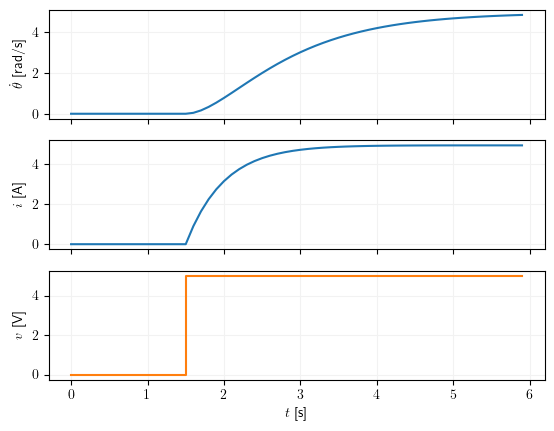

In [24]:
fig3 = plt.figure(3)
ax3a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\dot{\theta}$ [rad/s]")
plt.setp(ax3a, xticklabels=[])
ax3b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$i$ [A]")
plt.setp(ax3b, xticklabels=[])
ax3c = plt.subplot(313)
plt.step(t, v, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [V]")
plt.xlabel(r"$t$ [s]")
plt.show()

#### Closed-Loop Control

Let's now apply our controller design methodology for second-order systems.  Using the derived motor model (in the Laplace domain), we have

$$
\begin{align*}
a &= \frac{K_{\textup{t}}}{JL} \\
b &= \frac{b_{\textup{f}}L+RJ}{JL} \\
c &= \frac{b_{\textup{f}}R+K_{\textup{e}}K_{\textup{t}}}{JL}.
\end{align*}
$$

Like before, our design parameter is the closed-loop bandwidth $\omega_{\textup{CL}}>0$ and the pre-filter cutoff frequency is $\omega_{\textup{c}}=2\omega_{\textup{CL}}$ as `OMEGA_C`.  

In [25]:
# Set the desired closed-loop bandwidth [rad/s]
OMEGA_CL = 3.0

# Compute the filter cutoff frequency [rad/s]
OMEGA_C = 2.0 * OMEGA_CL

# Compute the model parameters
a = K_T / (J * L)
b = (B_FRICTION * L + R * J) / (J * L)
c = (B_FRICTION * R + K_E * K_T) / (J * L)

# Compute the corresponding controller gains
k_P = b * OMEGA_CL / (2.0 * a)
k_I = c * OMEGA_CL / (2.0 * a)
k_D = OMEGA_CL / (2.0 * a)

Now we write a class for a PID controller with post-filter.  We use a first-order difference approximation for the derivative of the error, and use a low-pass filter as describe in this note: [How to Implement a First-Order Low-Pass Filter in Discrete Time](https://github.com/botprof/first-order-low-pass-filter).

In [26]:
class PID_Controller:
    """Proportional-Integral-Derivative (PID) controller class."""

    def __init__(self, k_P, k_I, k_D, u_max, T):
        """Constructor method.

        Parameters
        ----------
        k_P : float
            Proportional gain.
        k_I : float
            Integral gain.
        k_D : float
            Derivative gain.
        u_max : float
            Maximum control signal output.
        T : float
            Sample period [s].
        """

        self.k_P = k_P
        self.k_I = k_I
        self.k_D = k_D
        self.T = T
        self.e_last = 0.0
        self.y_last = 0.0
        self.e_integral = 0.0
        self.e_derivative = 0.0
        self.u_max = u_max

    def compute_PID(self, e):
        """Compute the controller output.

        Parameters
        ----------
        e : float
            Error signal.

        Returns
        -------
        u : float
            Control signal (controller output).
        """

        # Compute the (first-order) derivative of the error
        self.e_derivative = (e - self.e_last) / T

        # Compute the control signal
        u = self.k_P * e + self.k_I * self.e_integral + self.k_D * self.e_derivative

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # Only integrate if control signal is not saturated
            self.e_integral += self.T * e

        # Save the latest error
        self.e_last = e

        return u

Run the simulation with PID control.

In [27]:
# Set the desired speed [rad/s] and maximum input voltage [V]
SPEED_D = 4.0
V_MAX = 12.0

# Create the controller object
controller = PID_Controller(k_P, k_I, k_D, V_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
v = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
v[0] = 0.0

for k in range(1, N):
    # Run the motor speed model for one time step
    x[:, k] = motor_speed(x[:, k - 1], v[k - 1])
    # Compute the control signal
    v[k] = controller.compute_PID(SPEED_D - x[0, k])

Plot the simulation results.

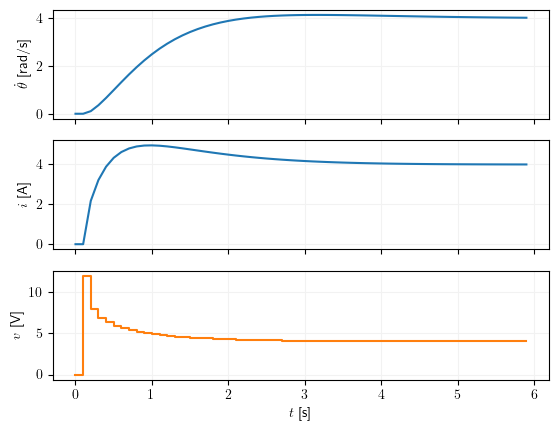

In [28]:
fig4 = plt.figure(3)
ax4a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\dot{\theta}$ [rad/s]")
plt.setp(ax4a, xticklabels=[])
ax4b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$i$ [A]")
plt.setp(ax4b, xticklabels=[])
ax4c = plt.subplot(313)
plt.step(t, v, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [V]")
plt.xlabel(r"$t$ [s]")
plt.show()

## References

1. G. F. Franklin, J. D. Powell, and A. Emami-Naeini, *Feedback Control of Dynamic Systems*. Pearson Prentice Hall, 5th ed., 2006.

2. J. Doyle, B. Francis, and A. Tannenbaum, *Feedback Control Theory*. Macmillan Publishing Co., 1990.

3. R. Mukherji, *MDR Controls Course: Time and Frequency Domain Methods for Continuous Systems*, MDA Space Missions, Brampton, ON Canada, November 2003.